# 04. PyTorch Custom Datasets

We'll use `torchvision.datasets` to build custom datasets. 

#### The contents

Topic	Contents
0. Importing PyTorch and setting up device-agnostic code.
1. Get data	We're going to be using our own custom dataset of pizza, steak and sushi images.
2. Become one with the data (data preparation)	
3. Transforming data - here we'll look at some steps we can take to transform our images so they're ready to be used with a model.
4. Loading data with ImageFolder (option 1)	 ImageFolder is helpful if our images are in standard image classification format.
5. Loading image data with a custom Dataset	What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.
6. Other forms of transforms (data augmentation) 
7. Model 0: TinyVGG without data augmentation
8. Exploring loss curves
9. Model 1: TinyVGG with data augmentation
10. Compare model results	
11. Making a prediction on a custom image trained model predict on an image outside of our existing dataset.

In [23]:
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import seaborn as sns 

print(f"version {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

version 2.1.2+cu118


'cuda'

### 1. Get data

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

PyTorch has a small version of that for learning pourposes with the 
- `torchvision.datasets.Food101`


In [24]:
import requests
import zipfile 
from pathlib import Path 

# setup path to root folder 
data_path = Path("D:\\Coding_Stuff\\")
image_path = data_path / "FoodVision"

# if image folder doses not exist, download it and prepare... 
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Did not find {image_path} directory, creating one.....")
    image_path.mkdir(parents=True, exist_ok=True)

    # download the data
    with open(data_path / "FoodVision.zip" , "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza_steak_sushi.........")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "FoodVision.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data.......")
        zip_ref.extractall(image_path)

D:\Coding_Stuff\FoodVision directory exists


### 2.Become one with data ( data prep)

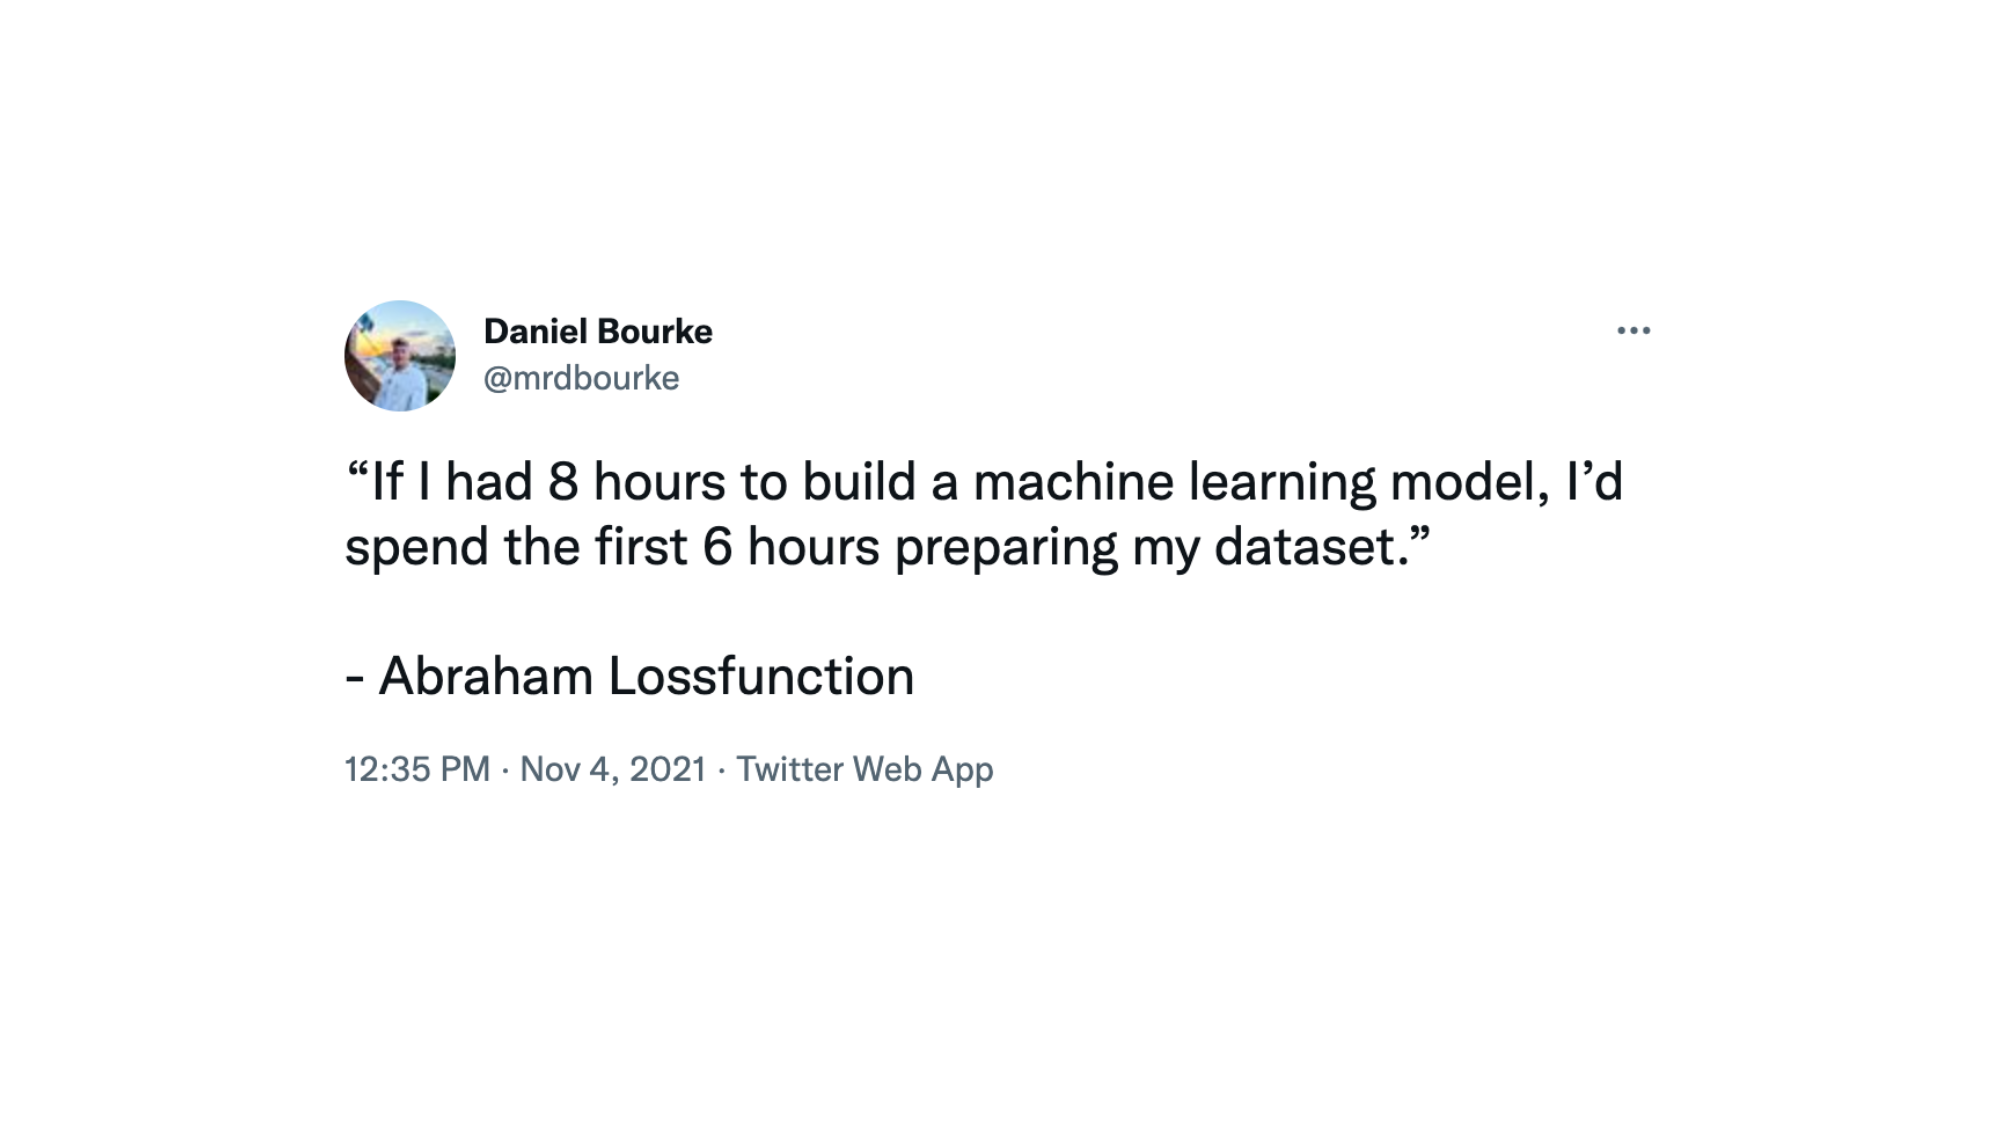

In [25]:
# We'll use os.walk()
import os 
def walk_through_dir(dir_path):

    """
    Walks through dir_path returning its content.
    Args: 
    dir_path (str or path;ib.Path); target dairectory.
    Returns:
    A printout of number of subdairectory,images and each name.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("D:\\Coding_Stuff\\FoodVision")

There are 2 directories and 0 images in 'D:\Coding_Stuff\FoodVision'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\FoodVision\test'.
There are 0 directories and 25 images in 'D:\Coding_Stuff\FoodVision\test\pizza'.
There are 0 directories and 19 images in 'D:\Coding_Stuff\FoodVision\test\steak'.
There are 0 directories and 31 images in 'D:\Coding_Stuff\FoodVision\test\sushi'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\FoodVision\train'.
There are 0 directories and 78 images in 'D:\Coding_Stuff\FoodVision\train\pizza'.
There are 0 directories and 75 images in 'D:\Coding_Stuff\FoodVision\train\steak'.
There are 0 directories and 72 images in 'D:\Coding_Stuff\FoodVision\train\sushi'.


In [26]:
# setting image path
train_dir = image_path / "train"
test_dir = image_path / "test" 

train_dir,test_dir

(WindowsPath('D:/Coding_Stuff/FoodVision/train'),
 WindowsPath('D:/Coding_Stuff/FoodVision/test'))

### 1.2 Visualize an image.

1. Get all of image path using `pathlib.Path.glob()` to find all path ending with `.jpg`
2. Pick a random image path using Python's `random.choice()`.
3. get image path usnig `pathlib.Path.parent.stem`
4. open the random image using `PIL.Image.open()`
5. print some metadata.

Random image path: D:\Coding_Stuff\FoodVision\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


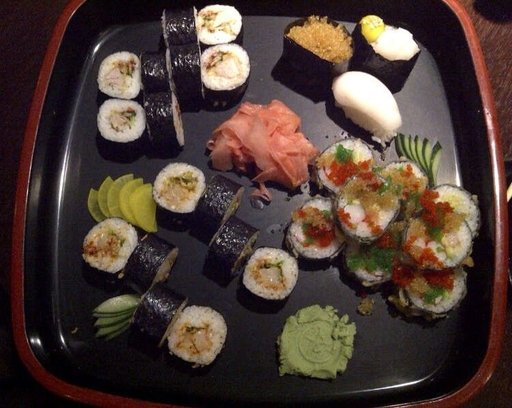

In [27]:
from PIL import Image
from pathlib import Path
import random 

# set seed 
random.seed(42)

# Get image path 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get random image
random_image_path = random.choice(image_path_list)

# Get image class from path 
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### 3.Transforming Data 

Using `torch.utils.data.Dataset` we turn images into Pytorch Dataset and later subsequently into `torch.utils.data.DataLoader`.

There are several kinds of datasets, for each data.

Problem space	Pre-built Datasets and Functions
- Vision	torchvision.datasets
- Audio	torchaudio.datasets
- Text	torchtext.datasets
- Recommendation system	torchrec.datasets

we'll use `torchvision.dataset` for dataloading we'll use `torchvision.transform`.

In [28]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

`torchvision.transforms` have pre-built functions to format images, turning them into tensors and manipulating them for **data augmentation** . 
- `transforms.Rezise()`
- `transforms.randomHorizondalFlip()`
- `trnasforms.ToTensor()`

we compile all this using `torchvision.transforms.Compose()`.

In [29]:
# write transforms for image
data_transform = transforms.Compose([
    # Reszie image
    transforms.Resize(size=(64,64)),
    # Flip the image randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch.tensor
    transforms.ToTensor()
])

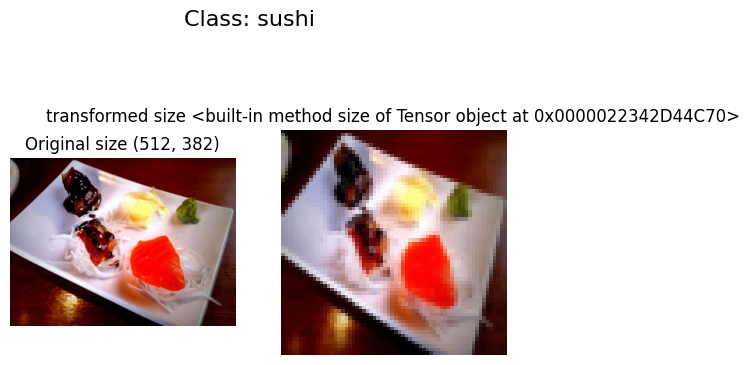

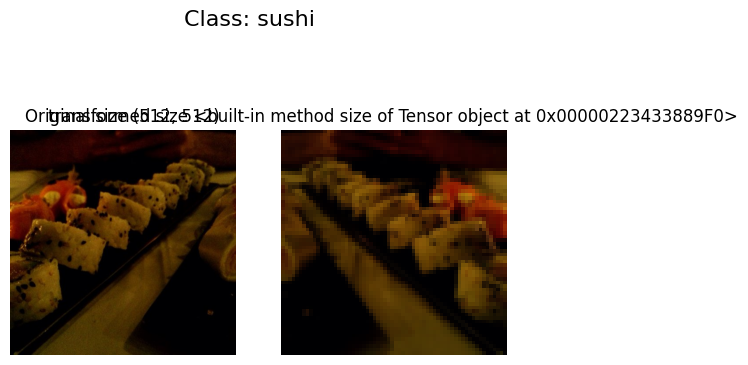

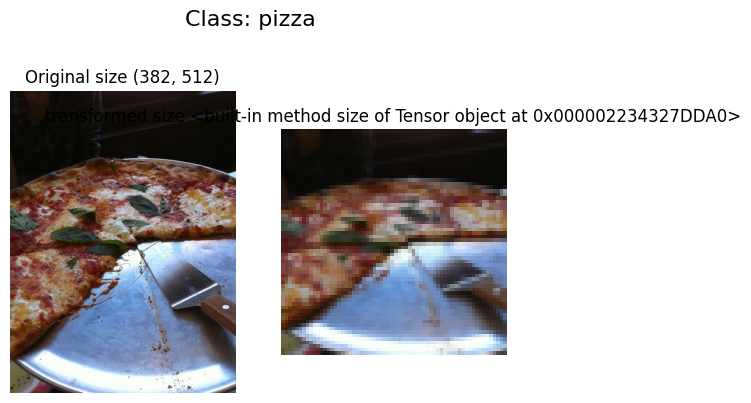

In [30]:
def plot_transformed_images(image_paths: list, transform , n=3, seed = None):
    """
    Plot a series of random image from image_paths by taking 
    a random image.

    Args:
        image_paths (list): List of image paths
        transform (PyTorch transform): transformation pipeline 
        n (int): number of sample
        seed (int, optional)
    """

    random.seed(seed)
    random_image_paths = random.sample(image_path_list, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original size {f.size}")
            ax[0].axis("off")

            # transform applied 
            # Note: permute() will change shape of image , it shift axis
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed size {transformed_image.size}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### 4. Option 1: Loading Image Data Using `ImageFolder`

Since our data us standard image classification format, we can use the `torchvision.datasets.ImageFolder`. 


In [31]:
# Use ImageFolder to create dataset(s).

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform,
                                target_transform=None)

print(f"Train Data \n {train_data}  Test Data \n {test_dir}")

Train Data 
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: D:\Coding_Stuff\FoodVision\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )  Test Data 
 D:\Coding_Stuff\FoodVision\test


In [32]:
print(f"Class names :{train_data.classes}")
print(f"converting class names to dict ; {train_data.class_to_idx}")
print(f"Len of class : {len(train_data)}")

# sample image and label from traindata
img,label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Class names :['pizza', 'steak', 'sushi']
converting class names to dict ; {'pizza': 0, 'steak': 1, 'sushi': 2}
Len of class : 225
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Text(0.5, 1.0, 'pizza')

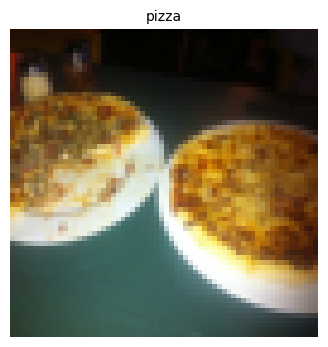

In [33]:
# Rearrange the order of dimensions
img = img.permute(1,2,0)

#plotting the image 
plt.figure(figsize=(7,4))
plt.imshow(img)
plt.axis("off")
plt.title(train_data.classes[label], fontsize = 10)

#### 4.1 loading data using DataLoader 

we'll do sousing `torch.utils.data.DataLoader`, to keep things simple we'll 

Use `batch_size = 1` and `num_worker=1`(It defines how many subprocesses will be created to load your data).

In [35]:
print(f"Number of CPUs {os.cpu_count()}")

# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

Number of CPUs 8


(<torch.utils.data.dataloader.DataLoader at 0x223434afa90>,
 <torch.utils.data.dataloader.DataLoader at 0x223434aeb30>)

In [36]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 5. Option 2: Loading Image data with Custom `Dataset`

- pros and cons of own custom way to load `Dataset`

Pros of creating a custom Dataset	
1. Can create a Dataset out of almost anything.	
2. Not limited to PyTorch pre-built Dataset functions.

Cons of creating a custom Dataset

1. Even though you could create a Dataset out of almost anything, it doesn't mean it will work.
2. Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues.

Replicating the `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset.`

In [37]:
import os 
import torch 
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List
# Various types from Python's typing module to add type hints to our code.

#### 5.1 Creating helper function to get class names 

In [40]:
# torchvision.datasets.ImageFolder() could return class names 
# Let's replicate that

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [46]:
# setup path for target directory 
target_directory = train_dir
print(f"Target Directory {target_directory}")

# Get the classnames from target directory 
class_names = [entity.name for entity in  list(os.scandir(image_path/"train"))]
print(class_names)

Target Directory D:\Coding_Stuff\FoodVision\train
['pizza', 'steak', 'sushi']


In [ ]:
# Make function to find class names 

def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """
    Finds the class folder names in the target directory 
    Assumes the target-directory is in standard image classfication format.

    Args:
        directory (str): the path of target directory 
    Returns:
        Tuple[List[str]], Dict[str,int]: (list_of_class_names, dict(class_name:idx.....)) 
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """

    # get class name by scanning the target dir
    classes = sorted(entity.name for entity in list(os.scandir(image_path/"train"))if entity.is_dir())

    # raise an error if class_names not found 
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    # create a dictionary of index labels
    class_to_idx = {cl} 